In [6]:
import numpy as np
import pandas as pd
import joblib
import seaborn as sn

import sys
sys.path.insert(1, '../')

import seaborn
%matplotlib inline
sn.set_theme()

In [2]:
with open('D:/IIT/DDP/data/output/filtered_data.sav', 'rb') as f:
    filtered_data = joblib.load(f)

# extract displacement features

In [7]:
fps = 30
temporal_dims = None
temporal_window = None
stride_window = 3

In [ ]:
from BSOID.features.displacement_feats import *
from tqdm import tqdm

feats = []
for i in tqdm(range(len(filtered_data))):
    feats.append(extract_feats(filtered_data[i], fps))
feats = window_extracted_feats(feats, stride_window, temporal_window, temporal_dims)

with open('D:/IIT/DDP/data/output/displacement_feats.sav', 'wb') as f:
    joblib.dump(feats, f)

# check distribution of velocity

In [8]:
with open('D:/IIT/DDP/data/output/displacement_feats.sav', 'rb') as f:
    feats = joblib.load(f)
feats = np.vstack(feats)

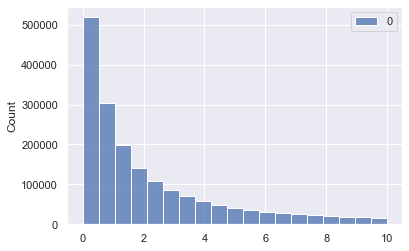

In [9]:
# tail and head displacement
head_dis = feats[:,7].reshape(-1,1)
tail_dis = feats[:,12:15].mean(axis=1).reshape(-1,1)
displacements = np.hstack((head_dis, tail_dis)).mean(axis=1).reshape(-1,1)
# displacements = feats[:,7:15].mean(axis=1).reshape(-1,1)
bins = np.linspace(displacements.min(), 10, 20)
sn.histplot(displacements, bins=bins)

# check examples of frames 

In [11]:
import os
from BSOID.preprocessing import likelihood_filter
from BSOID.prediction import frameshift_features
from BSOID.features.displacement_feats import *
from BSOID.utils import collect_all_examples

TEST_DIR = 'D:/IIT/DDP/data/test'

def dis_crit_feats(feats, dis_thresh):
    head_dis = feats[:,7].reshape(-1,1)
    tail_dis = feats[:,12:15].mean(axis=1).reshape(-1,1)
    displacements = np.hstack((head_dis, tail_dis)).mean(axis=1).reshape(-1,1)
    labels = np.array([int(displacements[i] >= dis_thresh) for i in range(displacements.shape[0])])
    return labels.flatten()

def frameshift_predict(feats, dis_thresh):
    labels = []
    for f in feats:
        labels.append(dis_crit_feats(f, dis_thresh))

    for n in range(len(labels)):
        labels[n] = labels[n][::-1]
    
    labels_pad = -1 * np.ones([len(labels), len(max(labels, key=lambda x: len(x)))])
    
    for n, l in enumerate(labels):
        labels_pad[n][0:len(l)] = l
        labels_pad[n] = labels_pad[n][::-1]

        if n > 0:
            labels_pad[n][0:n] = labels_pad[n-1][0:n]
    
    fs_labels = labels_pad.astype(int)
    fs_labels2 = []
    for l in range(stride_window):
        fs_labels2.append(fs_labels[l])
    fs_labels = np.array(fs_labels2).flatten('F')
    return fs_labels

def label_active_frames(csv_file, video_file, dis_thresh):
    output_dir = TEST_DIR + '/' + csv_file.split('/')[-1][:-4]
    try:
        os.makedirs(output_dir)
    except FileExistsError:
        pass
    
    frame_dir = f'{output_dir}/pngs'
    extract_frames = True
    try:
        os.makedirs(frame_dir)
    except FileExistsError:
        extract_frames = False
    
    if extract_frames:
        print('extracting frames from video {} to dir {}'.format(video_file, frame_dir))
        frames_from_video(video_file, frame_dir)
    
    print('extracting features from {}'.format(csv_file))
    
    data = pd.read_csv(csv_file, low_memory=False)
    data, _ = likelihood_filter(data)

    feats = frameshift_features(data, stride_window, fps, extract_feats, window_extracted_feats, temporal_window, temporal_dims)
    return frameshift_predict(feats, dis_thresh), frame_dir

def create_vids(csv_dir, vid_dir, dis_thresh, bout_length=3, n_examples=10):
    csv_files = [csv_dir + '/' + f for f in os.listdir(csv_dir) if f.endswith('.csv')]
    video_files = [vid_dir + '/' + f for f in os.listdir(vid_dir) if f.endswith('.avi')]

    csv_files.sort()
    video_files.sort()
    
    n_animals = len(csv_files)
    print(f'generating {n_examples} examples from {n_animals} videos each with minimum bout length of {1000 * bout_length / fps} ms and displacement threshold: {dis_thresh}')

    labels = []
    frame_dirs = []
    for i in range(n_animals):
        label, frame_dir = label_active_frames(csv_files[i], video_files[i], dis_thresh)
        labels.append(label)
        frame_dirs.append(frame_dir)

    output_path = f'{TEST_DIR}/dis_threshold'
    try:
        os.mkdir(output_path)
    except FileExistsError:
        print(f'results directory: {output_path} already exists, deleting')
        [os.remove(output_path+'/'+f) for f in os.listdir(output_path)]

    clip_len = None
    if temporal_window is not None:
        clip_len = (temporal_window - stride_window) // 2
    
    print(f'saving threshold videos to {output_path} with label 1 for active frames')
    collect_all_examples(labels, frame_dirs, output_path, clip_len, bout_length, n_examples, fps)

In [14]:
video_dir = 'D:/IIT/DDP/data/test/videos'
csv_dir = 'D:/IIT/DDP/data/test'

create_vids(csv_dir, video_dir, dis_thresh=1.0, n_examples=1)

generating 1 examples from 5 videos each with minimum bout length of 100.0 ms and displacement threshold: 1.0
extracting features from D:/IIT/DDP/data/test/LL1-4_100012-F-AX1-8-42430-4-S129_pose_est_v2.csv
extracting features from D:/IIT/DDP/data/test/LL4-3_B6SJLF1_F_pose_est_v2.csv
extracting features from D:/IIT/DDP/data/test/LL4-4_B6N_ControlMale-7-PSY_pose_est_v2.csv
extracting features from D:/IIT/DDP/data/test/LL6-2_B6N_Male_S6889224_ep2-BAT_pose_est_v2.csv
extracting features from D:/IIT/DDP/data/test/WT001G15N5F100227F-27-PSY_pose_est_v2.csv
results directory: D:/IIT/DDP/data/test/dis_threshold already exists, deleting
saving threshold videos to D:/IIT/DDP/data/test/dis_threshold with label 1 for active frames
